# Wind Layout Optimization

In [1]:
import os
from time import time
from pathlib import Path

import yaml
import json
import numpy as np
from matplotlib import pyplot as plt
from pyoptsparse import NSGA2, ALPSO, IPOPT, SNOPT
from pyoptsparse import Optimization

from hopp import ROOT_DIR
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site
from hopp.simulation.hybrid_simulation import HybridSimulation
from hopp.simulation.technologies.layout.wind_layout import WindCustomParameters
from hopp.simulation.technologies.layout.wind_layout_tools import create_grid
from hopp.utilities.log import hybrid_logger as logger
from hopp.utilities.keys import set_nrel_key_dot_env

/Users/cirmas/workspace/wind-layout/log/hybrid_systems_2023-09-12T13.05.58.692621.log


In [2]:
# Set API key
set_nrel_key_dot_env()

## Define HOPP system functions

In [3]:
def load_config(path):
    with open(path, 'r') as f:
        return yaml.load(f, yaml.SafeLoader)

In [4]:
def create_verts(x0, y0, w, h):
    verts = [
        [x0, y0],
        [x0+w, y0],
        [x0+w, y0+h],
        [x0, y0+h]
    ]
    return verts

In [5]:
def create_site(data, **kwargs):
    solar_resource_file = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
    wind_resource_file = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
    prices_file = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv";
    
    site = SiteInfo(
        data, 
        solar_resource_file=solar_resource_file, 
        wind_resource_file=wind_resource_file, 
        grid_resource_file=prices_file,
        **kwargs
    )

    return site

In [6]:
def create_layout(site, n_turbines):
    turbine_positions = create_grid(
        site.polygon,
        site.polygon.centroid,
        0, # angle
        200, # intrarow spacing
        200, # interrow spacing
        0, # row phase offset
        max_sites = N_TURBINES
    )

    return turbine_positions

In [7]:
def plot_layout(site, layout):
    fig, ax = site.plot()
    xs = [v.x for v in layout]
    xy = [v.y for v in layout]
    ax.scatter(xs, xy)

In [8]:
def create_hybrid_plant(site, tech_keys=None):
    tech_keys = tech_keys or ["wind", "grid"]

    hybrid_config = {}

    # only use desired tech
    for k in tech_keys:
        hybrid_config[k] = technologies[k]

    # create system model
    hybrid_plant = HybridSimulation(hybrid_config, site)
    hybrid_plant.ppa_price = 0.01
    # hybrid_plant.pv.dc_degradation = [0] * 25

    return hybrid_plant

## Define Optimization functions

In [9]:
def setup_opt(layout, opt="snopt"):
    # initialize optimization object
    n_turbines = len(layout)
    optProb = Optimization("Wind Farm Layout Problem", objective)

    x_coords = [t.x for t in layout]
    y_coords = [t.y for t in layout]
    
    optProb.addVarGroup("x_coords", n_turbines, lower=0, upper=site_w, value=x_coords)
    optProb.addVarGroup("y_coords", n_turbines, lower=0, upper=site_h, value=y_coords)

    # add objective
    optProb.addObj("obj")

    # set up optimizer
    optimizer_mapping = {
        "nsga2": (NSGA2, {"PopSize": 10, "maxGen": 10}),
        "alpso": (ALPSO, {"SwarmSize": 5, "maxOuterIter": 10}),
        "snopt": (SNOPT, {
            "Verify level": 0,
            "Major optimality tolerance": 1E-6,
        }),
        "ipopt": (IPOPT, {})
    }

    optimizer_class, opt_options = optimizer_mapping.get(opt, (None, None))
    if optimizer_class:
        opt = optimizer_class(options=opt_options)
    else:
        raise ValueError(f"Unknown optimizer: {opt}")

    return opt, optProb

In [10]:
# set up objective function
def objective(xdict):
    funcs = {}
    
    x_coords = np.asarray(xdict["x_coords"])
    y_coords = np.asarray(xdict["y_coords"])

    floris_config = load_config("floris_input.yaml")
    floris_config["farm"]["layout_x"] = x_coords
    floris_config["farm"]["layout_y"] = y_coords
    
    technologies["wind"]["floris_config"] = floris_config
    hybrid_plant = create_hybrid_plant(site)

    print("x: ", x_coords)
    print("y: ", y_coords)

    # run simulation
    hybrid_plant.simulate(25)
    
    # get result
    funcs["obj"] = -hybrid_plant.annual_energies.hybrid
    
    # set fail flag
    fail = False
    return funcs, fail

## System configuration

In [11]:
N_TURBINES = 6

# Set wind, solar, and interconnection capacities (in MW)
solar_size_mw = 50
wind_size_mw = 50
interconnection_size_mw = 50

floris_config = "floris_input.yaml"

# specify which technologies to include in the system
technologies = {
    'pv': {
        'system_capacity_kw': solar_size_mw * 1000
    },
    'wind': {
        'model_name': 'floris',
        'num_turbines': N_TURBINES,
        'turbine_rating_kw': 5000,
        'timestep': [0,8760],
    },
    'battery': {
        'system_capacity_kwh': 100,
        'system_capacity_kw': 100
    },
    'grid': {
        'interconnect_kw': interconnection_size_mw * 1000
    }
}

In [12]:
site_data = flatirons_site
site_w = 600
site_h = 600
verts = create_verts(0, 0, site_w, site_h)
site_data["site_boundaries"]["verts"] = verts
site = create_site(site_data)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x (m)', ylabel='y (m)'>)

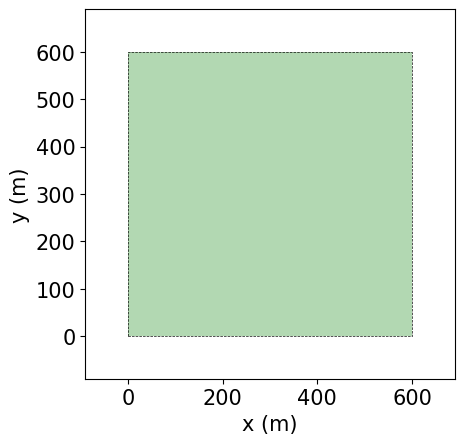

In [13]:
site.plot()

In [14]:
layout = create_layout(site, N_TURBINES)

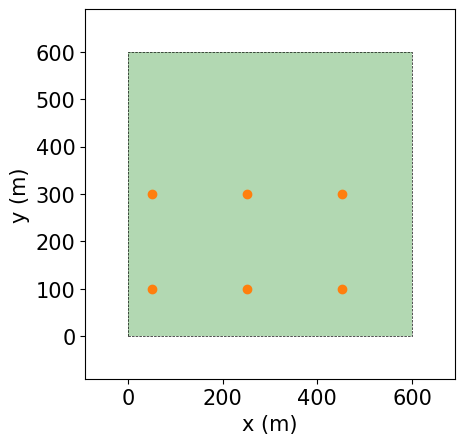

In [15]:
plot_layout(site, layout)

## Run Opt

In [16]:
opt, opt_prob = setup_opt(layout)

In [17]:
if os.path.exists("./SNOPT_print.out"):
    os.remove("./SNOPT_print.out")

if os.path.exists("./SNOPT_summary.out"):
    os.remove("./SNOPT_summary.out")

In [18]:
sol = opt(opt_prob, sens="FD")

FLORIS is the system model...
x:  [ 51.47186255 251.47186255 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215533.30963817
FLORIS is the system model...
x:  [ 51.47186355 251.47186255 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215536.08972415
FLORIS is the system model...
x:  [ 51.47186255 251.47186355 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215525.15213954
FLORIS is the system model...
x:  [ 51.47186255 251.47186255 451.47186355  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215532.60717677
FLORIS is the system model...
x:  [ 51.47186255 251.47186255 451.47186255  5

Wind annual energy:  88195077.02787372
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517301 251.36031771
 451.53774486]
y:  [100.22178394  99.95564321  99.95564321 299.86692964 299.86692964
 299.86692964]
Simulating wind farm output in FLORIS...
Wind annual energy:  88195079.08097288
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517201 251.36031871
 451.53774486]
y:  [100.22178394  99.95564321  99.95564321 299.86692964 299.86692964
 299.86692964]
Simulating wind farm output in FLORIS...
Wind annual energy:  88195067.99475752
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517201 251.36031771
 451.53774586]
y:  [100.22178394  99.95564321  99.95564321 299.86692964 299.86692964
 299.86692964]
Simulating wind farm output in FLORIS...
Wind annual energy:  88195061.87860614
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517201 251.36031771
 451.53774486]
y:  [1

Wind annual energy:  88215263.52908276
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [100.00272113  99.99945677  99.99945577 299.99836732 299.99836732
 299.99836732]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215272.85501933
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [100.00272113  99.99945577  99.99945677 299.99836732 299.99836732
 299.99836732]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215279.40217246
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [100.00272113  99.99945577  99.99945577 299.99836832 299.99836732
 299.99836732]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215260.0074564
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [10

Wind annual energy:  88215536.38427705
FLORIS is the system model...
x:  [ 51.47186263 251.47186251 451.47186248  51.47186263 251.47186251
 451.47186257]
y:  [100.00000007  99.99999999  99.99999999 299.99999996 299.99999996
 300.00000096]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215528.7328154
FLORIS is the system model...
x:  [ 51.47186255 251.47186255 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215516.12340094
FLORIS is the system model...
x:  [ 51.47186355 251.47186255 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215517.46057302
FLORIS is the system model...
x:  [ 51.47186255 251.47186355 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  8821552

Wind annual energy:  88195077.02787372
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517301 251.36031771
 451.53774486]
y:  [100.22178394  99.95564321  99.95564321 299.86692964 299.86692964
 299.86692964]
Simulating wind farm output in FLORIS...
Wind annual energy:  88195079.08097288
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517201 251.36031871
 451.53774486]
y:  [100.22178394  99.95564321  99.95564321 299.86692964 299.86692964
 299.86692964]
Simulating wind farm output in FLORIS...
Wind annual energy:  88195067.99475752
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517201 251.36031771
 451.53774586]
y:  [100.22178394  99.95564321  99.95564321 299.86692964 299.86692964
 299.86692964]
Simulating wind farm output in FLORIS...
Wind annual energy:  88195061.87860614
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517201 251.36031771
 451.53774486]
y:  [1

Wind annual energy:  88215263.52908276
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [100.00272113  99.99945677  99.99945577 299.99836732 299.99836732
 299.99836732]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215272.85501933
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [100.00272113  99.99945577  99.99945677 299.99836732 299.99836732
 299.99836732]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215279.40217246
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [100.00272113  99.99945577  99.99945577 299.99836832 299.99836732
 299.99836732]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215260.0074564
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [10

Wind annual energy:  88215536.38427705
FLORIS is the system model...
x:  [ 51.47186263 251.47186251 451.47186248  51.47186263 251.47186251
 451.47186257]
y:  [100.00000007  99.99999999  99.99999999 299.99999996 299.99999996
 300.00000096]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215528.7328154
FLORIS is the system model...
x:  [ 51.47186255 251.47186255 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215516.12340094
FLORIS is the system model...
x:  [ 51.47186355 251.47186255 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215517.46057302
FLORIS is the system model...
x:  [ 51.47186255 251.47186355 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  8821552

Wind annual energy:  88195077.02787372
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517301 251.36031771
 451.53774486]
y:  [100.22178394  99.95564321  99.95564321 299.86692964 299.86692964
 299.86692964]
Simulating wind farm output in FLORIS...
Wind annual energy:  88195079.08097288
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517201 251.36031871
 451.53774486]
y:  [100.22178394  99.95564321  99.95564321 299.86692964 299.86692964
 299.86692964]
Simulating wind farm output in FLORIS...
Wind annual energy:  88195067.99475752
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517201 251.36031771
 451.53774586]
y:  [100.22178394  99.95564321  99.95564321 299.86692964 299.86692964
 299.86692964]
Simulating wind farm output in FLORIS...
Wind annual energy:  88195061.87860614
FLORIS is the system model...
x:  [ 51.71517201 251.36031771 451.27160413  51.71517201 251.36031771
 451.53774486]
y:  [1

Wind annual energy:  88215263.52908276
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [100.00272113  99.99945677  99.99945577 299.99836732 299.99836732
 299.99836732]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215272.85501933
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [100.00272113  99.99945577  99.99945677 299.99836732 299.99836732
 299.99836732]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215279.40217246
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [100.00272113  99.99945577  99.99945577 299.99836832 299.99836732
 299.99836732]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215260.0074564
FLORIS is the system model...
x:  [ 51.47484778 251.47049397 451.46940552  51.47484778 251.47049397
 451.47267088]
y:  [10

Wind annual energy:  88215536.38427705
FLORIS is the system model...
x:  [ 51.47186263 251.47186251 451.47186248  51.47186263 251.47186251
 451.47186257]
y:  [100.00000007  99.99999999  99.99999999 299.99999996 299.99999996
 300.00000096]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215528.7328154
FLORIS is the system model...
x:  [ 51.47186255 251.47186255 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215516.12340094
FLORIS is the system model...
x:  [ 51.47186355 251.47186255 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  88215517.46057302
FLORIS is the system model...
x:  [ 51.47186255 251.47186355 451.47186255  51.47186255 251.47186255
 451.47186255]
y:  [100. 100. 100. 300. 300. 300.]
Simulating wind farm output in FLORIS...
Wind annual energy:  8821552

## Analysis

In [19]:
print(sol)



Optimization Problem -- Wind Farm Layout Problem
    Objective Function: objective

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                  746.4253
       User Objective Time :      59.6457
       User Sensitivity Time :   686.7541
       Interface Time :            0.0173
       Opt Solver Time:            0.0081
    Calls to Objective Function :      23
    Calls to Sens Function :           22


   Objectives
      Index  Name            Value
          0  obj    -8.821552E+07

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name         Type      Lower Bound            Value      Upper Bound     Status
          0  x_coords_0      c     0.000000E+00     5.147186E+01     6.000000E+02           
          1  x_coords_1      c     0.000000E+00     2.514719E+02     6.000000E+02           
          2  x_coords_2      c     0.000000E+00     4.514719E+02     6.000000E+02           
         